In [98]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from itertools import product

In [99]:
class HIVSpatioTemporalModel:
    def __init__(self, name: str, geo_data_path: str = 'ua.json'):
        self.name = name
        self.gdf = gpd.read_file(geo_data_path)
        self.geo_to_data_names = {
            'UA71': 'Черкаська', 'UA74': 'Чернігівська', 'UA77': 'Чернівецька',
            'UA12': 'Дніпропетровська', 'UA14': 'Донецька', 'UA26': 'Івано-Франківська',
            'UA63': 'Харківська', 'UA65': 'Херсонська', 'UA68': 'Хмельницька',
            'UA30': 'Київська', 'UA35': 'Кіровоградська', 'UA09': 'Луганська',
            'UA46': 'Львівська', 'UA48': 'Миколаївська', 'UA51': 'Одеська',
            'UA53': 'Полтавська', 'UA56': 'Рівненська', 'UA59': 'Сумська',
            'UA61': 'Тернопільська', 'UA05': 'Вінницька', 'UA07': 'Волинська',
            'UA21': 'Закарпатська', 'UA23': 'Запорізька', 'UA18': 'Житомирська',
            'UA32': 'Київ', 'UA43': 'Крим'
        }
        self.region_to_idx = {region_id: idx for idx, region_id in enumerate(self.geo_to_data_names.keys())}
        self.gdf_filtered = self.gdf[self.gdf['id'].isin(self.geo_to_data_names.keys())]
        self.model = None
        self.trace = None
        self.n_regions = len(self.geo_to_data_names)
        self.n_months = None
        self.train_df = None
        self.test_df = None
        self._prediction_counter = 0
        
    def prepare_data(self, data_path: str, start_date: None, end_date: None):
        df = pd.read_csv(data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Додаємо колонку Total_Rate як суму HIV_Rate та AIDS_Rate
        df['Total_Rate'] = df['HIV_Rate'] + df['AIDS_Rate']
        
        if start_date:
            df = df[df['Date'] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df['Date'] <= pd.to_datetime(end_date)]
        
        df['month_idx'] = (df['Date'].dt.year - df['Date'].dt.year.min()) * 12 + df['Date'].dt.month - 1
        df['region_id'] = df['Region'].map({v: k for k, v in self.geo_to_data_names.items()})
        df['region_idx'] = df['region_id'].map(self.region_to_idx)
        
        self.train_df, self.test_df = train_test_split(df, test_size=0.3, shuffle=False)
        self.n_months = int(df['month_idx'].max() + 1)
        
    def build_model(self, region_sigma=10, time_sigma=10, sigma_obs=1):
        """Лінійна Байєсівська модель модель: регіональна компонента + часовий тренд + шум"""
        with pm.Model() as self.model:
            # Регіональна компонента
            region_means = pm.Normal("region_means", mu=0, sigma=region_sigma, shape=self.n_regions)
            
            # Часова компонента
            time_trend = pm.Normal("time_trend", mu=0, sigma=time_sigma, shape=round(self.n_months*1.5))
            
            # Загальний шум спостережень
            sigma_obs = pm.Normal("sigma_obs", mu=0, sigma=sigma_obs)
            
            # Лінійна комбінація
            mu = pm.Deterministic(
                "mu",
                region_means[self.train_df['region_idx'].values] + 
                time_trend[self.train_df['month_idx'].values]
            )
            
            # цільовий Total_Rate
            pm.Normal("total_rate", mu=mu, sigma=sigma_obs, observed=self.train_df["Total_Rate"].values)
    
    def train_model(self, samples=2000, tune=1000, chains=4):
        if self.model is None:
            raise ValueError("Модель не побудована. Спочатку викличте build_model().")
            
        with self.model:
            self.trace = pm.sample(
                samples,
                tune=tune,
                chains=chains,
                target_accept=0.95,
                return_inferencedata=True,
                random_seed=10
            )
        return self.trace
    
    def evaluate_model(self, silent=False):
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        with self.model:
            pred_var_name = f"pred_mu_{self._prediction_counter}"
            self._prediction_counter += 1
            
            pm.Deterministic(
                pred_var_name,
                self.model["region_means"][self.test_df['region_idx'].values] +
                self.model["time_trend"][self.test_df['month_idx'].values]
            )
            
            test_predictions = pm.sample_posterior_predictive(
                self.trace, 
                var_names=[pred_var_name]
            )

        y_true = self.test_df["Total_Rate"].values  # Зміна тут
        y_pred = test_predictions.posterior_predictive[pred_var_name].mean(dim=["chain", "draw"]).values
        
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        valid_idx = y_true != 0
        mape = np.mean(np.abs((y_true[valid_idx] - y_pred[valid_idx]) / y_true[valid_idx])) * 100

        test_df_with_pred = self.test_df.copy()
        test_df_with_pred['Prediction'] = y_pred
        mape_by_region = {}
        
        for region_name, region_data in test_df_with_pred.groupby('Region'):
            region_y_true = region_data['Total_Rate'].values  # Зміна тут
            region_y_pred = region_data['Prediction'].values
            valid_idx = region_y_true != 0
            if np.any(valid_idx):
                region_mape = np.mean(np.abs((region_y_true[valid_idx] - region_y_pred[valid_idx]) / 
                                    region_y_true[valid_idx])) * 100
                mape_by_region[region_name] = region_mape
        
        mape_by_region = dict(sorted(mape_by_region.items(), key=lambda item: item[1]))
        
        print("\nОцінка якості моделі:")
        print("+----------------+------------+")
        print("| Metric         | Value      |")
        print("+----------------+------------+")
        print(f"| R²             | {r2:.3f}     |")
        print(f"| MAE            | {mae:.2f}     |")
        print(f"| MAPE           | {mape:.1f}%    |")
        print("+----------------+------------+")
            
        if not silent:   
            self._plot_regional_mape(mape_by_region, mape)
        
        return {
            'MAE': mae,
            'R2': r2,
            'MAPE': mape,
            'MAPE_by_region': mape_by_region
        }

    def predict_total_rate(self, date: str) -> pd.DataFrame:
        """
        Прогнозує загальний рівень ВІЛ+СНІД для всіх регіонів на задану дату.
        """
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        date = pd.to_datetime(date)
        min_date = self.train_df['Date'].min()
        month_idx = (date.year - min_date.year) * 12 + date.month - min_date.month
        
        pred_var_name = f"pred_mu_{self._prediction_counter}"
        self._prediction_counter += 1
        
        with self.model:
            pm.Deterministic(
                pred_var_name,
                self.model["region_means"][list(range(self.n_regions))] + 
                self.model["time_trend"][month_idx]
            )
            
            predictions = pm.sample_posterior_predictive(
                self.trace, 
                var_names=[pred_var_name],
                progressbar=False
            )
        
        pred_means = predictions.posterior_predictive[pred_var_name].mean(dim=["chain", "draw"]).values
        
        return pd.DataFrame({
            "Region": list(self.geo_to_data_names.values()),
            "Region_ID": list(self.geo_to_data_names.keys()),
            "Total_Rate_Pred": pred_means,  # Зміна тут
            "Date": date
        })

    def plot_spatial_comparison(self, date: str):
        date = pd.to_datetime(date)
        pred = self.predict_total_rate(date)  # Зміна тут
        actual = self.test_df[self.test_df['Date'] == date].copy()
        
        actual['Region_Name'] = actual['Region']
        pred['Region_Name'] = pred['Region']
        
        gdf_actual = self.gdf_filtered.merge(
            actual[['region_id', 'Total_Rate', 'Region_Name']],  # Зміна тут
            left_on='id', right_on='region_id'
        )
        gdf_pred = self.gdf_filtered.merge(
            pred[['Region_ID', 'Total_Rate_Pred', 'Region_Name']],  # Зміна тут
            left_on='id', right_on='Region_ID'
        )

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        vmax = max(gdf_actual['Total_Rate'].max(), gdf_pred['Total_Rate_Pred'].max())  # Зміна тут
        
        for ax, gdf, title, col in zip([ax1, ax2], 
                                    [gdf_actual, gdf_pred],
                                    [f"Реальні дані ({date.strftime('%Y-%m')})", 
                                    f"Прогноз ({date.strftime('%Y-%m')})"],
                                    ['Total_Rate', 'Total_Rate_Pred']):  # Зміна тут
            
            gdf.plot(column=col, cmap='Reds', ax=ax, vmin=0, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
            
            for idx, row in gdf.iterrows():
                centroid = row['geometry'].centroid
                ax.annotate(
                    text=f"{row['Region_Name']}\n{row[col]:.1f}",
                    xy=(centroid.x, centroid.y),
                    ha='center',
                    fontsize=9,
                    color='black'
                )
            
            ax.set_title(title, fontsize=14)
            ax.set_axis_off()

        plt.suptitle("Порівняння реальних даних та прогнозу ВІЛ+СНІД", fontsize=16)  # Зміна тут
        plt.tight_layout()
        plt.show()

    def plot_spatial_prediction(self, date: str):
        date = pd.to_datetime(date)
        pred = self.predict_total_rate(date)
        
        pred['Region_Name'] = pred['Region']
        
        gdf = self.gdf_filtered.merge(
            pred[['Region_ID', 'Total_Rate_Pred', 'Region_Name']],
            left_on='id', right_on='Region_ID'
        )

        fig, ax = plt.subplots(figsize=(14, 8))
        vmin, vmax = 0, gdf['Total_Rate_Pred'].max()
        
            
        gdf.plot(column='Total_Rate_Pred', ax=ax, cmap='Reds', vmin=vmin, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
            
        for idx, row in gdf.iterrows():
            centroid = row['geometry'].centroid
            if row['Region_Name'] != 'Київська':
                ax.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                          xy=(centroid.x, centroid.y),
                          ha='center',
                          fontsize=9,
                          color='black')
            else:
                ax.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                          xy=(centroid.x, centroid.y-0.3),
                          ha='center',
                          fontsize=9,
                          color='black')
            
        ax.set_title(f"Прогноз ({date.strftime('%Y-%m')})", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()

    def plot_models_comparison(self, other_model, date: str):
        """
        Порівнює прогнози двох моделей на задану дату.
        
        Параметри:
            other_model: Інший екземпляр HIVSpatioTemporalModel для порівняння
            date: Дата для прогнозу у форматі 'YYYY-MM-DD'
        """
        date = pd.to_datetime(date)
        
        # Отримуємо прогнози для обох моделей
        pred1 = self.predict_total_rate(date)
        pred2 = other_model.predict_total_rate(date)
        
        # Готуємо дані для візуалізації
        pred1['Region_Name'] = pred1['Region']
        pred2['Region_Name'] = pred2['Region']
        
        gdf_pred1 = self.gdf_filtered.merge(
            pred1[['Region_ID', 'Total_Rate_Pred', 'Region_Name']],
            left_on='id', right_on='Region_ID'
        )
        gdf_pred2 = self.gdf_filtered.merge(
            pred2[['Region_ID', 'Total_Rate_Pred', 'Region_Name']],
            left_on='id', right_on='Region_ID'
        )

        # Визначаємо загальний масштаб для обох карт
        vmax = max(gdf_pred1['Total_Rate_Pred'].max(), gdf_pred2['Total_Rate_Pred'].max())
        
        # Створюємо фігуру
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        
        # Перша карта (поточна модель)
        gdf_pred1.plot(column='Total_Rate_Pred', cmap='Reds', ax=ax1, vmin=0, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
        
        for idx, row in gdf_pred1.iterrows():
            centroid = row['geometry'].centroid
            if row['Region_Name'] != 'Київська':
                ax1.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y),
                        ha='center',
                        fontsize=9,
                        color='black')
            else:
                ax1.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y-0.3),
                        ha='center',
                        fontsize=9,
                        color='black')
        
        ax1.set_title(f"Прогноз {self.name} ({date.strftime('%Y-%m')})", fontsize=14)
        ax1.set_axis_off()
        
        # Друга карта (інша модель)
        gdf_pred2.plot(column='Total_Rate_Pred', cmap='Reds', ax=ax2, vmin=0, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
        
        for idx, row in gdf_pred2.iterrows():
            centroid = row['geometry'].centroid
            if row['Region_Name'] != 'Київська':
                ax2.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y),
                        ha='center',
                        fontsize=9,
                        color='black')
            else:
                ax2.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y-0.3),
                        ha='center',
                        fontsize=9,
                        color='black')
        
        ax2.set_title(f"Прогноз {other_model.name} ({date.strftime('%Y-%m')})", fontsize=14)
        ax2.set_axis_off()
        
        plt.suptitle(f"Порівняння прогнозів ВІЛ+СНІД на {date.strftime('%Y-%m')}", fontsize=16)
        plt.tight_layout()
        plt.show()

    def _plot_regional_mape(self, mape_data: dict, overall_mape: float):
        plt.figure(figsize=(14, 8))
        bars = plt.bar(mape_data.keys(), mape_data.values(), color='skyblue')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        plt.axhline(y=overall_mape, color='red', linestyle='--', 
                linewidth=2, label=f'Середній MAPE: {overall_mape:.1f}%')
        
        plt.title('Відносна похибка (MAPE) по регіонах', fontsize=14)
        plt.ylim(0, 100)
        plt.ylabel('MAPE (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.legend(fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    def optimize_parameters(self, param_grid, samples: int = 2000, tune: int = 1000, silent=True):
        best_params = {}
        best_mape = float('inf')
        
        param_names = param_grid.keys()
        param_values = product(*param_grid.values())
        
        for values in param_values:
            params = dict(zip(param_names, values))
            print(f"\nТестуємо параметри: {params}")
            
            self.build_model(**params)
            self.train_model(samples=samples, tune=tune)
            metrics = self.evaluate_model(silent)
            
            if metrics['MAPE'] < best_mape:
                best_mape = metrics['MAPE']
                best_params = params.copy()
                best_params.update(metrics)
                print("Новий найкращий результат!")
        
        print(f"\nНайкращі параметри: {best_params}")
        return best_params
    
    def plot_models_comparison_with_actual(self, other_model, actual_data: dict, date: str):
        """
        Порівнює прогнози двох моделей з реальними даними на задану дату.
        
        Параметри:
            other_model: Інший екземпляр HIVSpatioTemporalModel для порівняння
            actual_data: Словник з реальними даними у форматі {область: значення}
            date: Дата для прогнозу у форматі 'YYYY-MM-DD'
        """
        date = pd.to_datetime(date)
        
        # Отримуємо прогнози для обох моделей
        pred1 = self.predict_total_rate(date)
        pred2 = other_model.predict_total_rate(date)
        
        # Готуємо DataFrame з реальними даними
        actual_df = pd.DataFrame({
            "Region": list(actual_data.keys()),
            "Total_Rate": list(actual_data.values())
        })
        actual_df['Region_ID'] = actual_df['Region'].map({v: k for k, v in self.geo_to_data_names.items()})
        
        # Готуємо дані для візуалізації
        pred1['Region_Name'] = pred1['Region']
        pred2['Region_Name'] = pred2['Region']
        actual_df['Region_Name'] = actual_df['Region']
        
        gdf_pred1 = self.gdf_filtered.merge(
            pred1[['Region_ID', 'Total_Rate_Pred', 'Region_Name']],
            left_on='id', right_on='Region_ID'
        )
        gdf_pred2 = self.gdf_filtered.merge(
            pred2[['Region_ID', 'Total_Rate_Pred', 'Region_Name']],
            left_on='id', right_on='Region_ID'
        )
        gdf_actual = self.gdf_filtered.merge(
            actual_df[['Region_ID', 'Total_Rate', 'Region_Name']],
            left_on='id', right_on='Region_ID'
        )

        # Визначаємо загальний масштаб для всіх карт
        vmax = max(
            gdf_pred1['Total_Rate_Pred'].max(), 
            gdf_pred2['Total_Rate_Pred'].max(),
            gdf_actual['Total_Rate'].max()
        )
        
        # Створюємо фігуру з трьома підграфіками
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))
        
        # Перша карта (поточна модель)
        gdf_pred1.plot(column='Total_Rate_Pred', cmap='Reds', ax=ax1, vmin=0, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
        
        for idx, row in gdf_pred1.iterrows():
            centroid = row['geometry'].centroid
            if row['Region_Name'] != 'Київська':
                ax1.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y),
                        ha='center',
                        fontsize=9,
                        color='black')
            else:
                ax1.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y-0.3),
                        ha='center',
                        fontsize=9,
                        color='black')
        
        ax1.set_title(f"Прогноз {self.name} ({date.strftime('%Y-%m')})", fontsize=14)
        ax1.set_axis_off()
        
        # Друга карта (інша модель)
        gdf_pred2.plot(column='Total_Rate_Pred', cmap='Reds', ax=ax2, vmin=0, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
        
        for idx, row in gdf_pred2.iterrows():
            centroid = row['geometry'].centroid
            if row['Region_Name'] != 'Київська':
                ax2.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y),
                        ha='center',
                        fontsize=9,
                        color='black')
            else:
                ax2.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate_Pred']:.1f}", 
                        xy=(centroid.x, centroid.y-0.3),
                        ha='center',
                        fontsize=9,
                        color='black')
        
        ax2.set_title(f"Прогноз {other_model.name} ({date.strftime('%Y-%m')})", fontsize=14)
        ax2.set_axis_off()
        
        # Третя карта (реальні дані)
        gdf_actual.plot(column='Total_Rate', cmap='Reds', ax=ax3, vmin=0, vmax=vmax,
                    legend=True, edgecolor='black', linewidth=0.3, missing_kwds={
                       'color': 'lightgrey',
                       'label': 'Немає даних'
                   })
        
        for idx, row in gdf_actual.iterrows():
            centroid = row['geometry'].centroid
            if row['Region_Name'] != 'Київська':
                ax3.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate']:.1f}", 
                        xy=(centroid.x, centroid.y),
                        ha='center',
                        fontsize=9,
                        color='black')
            else:
                ax3.annotate(text=f"{row['Region_Name']}\n{row['Total_Rate']:.1f}", 
                        xy=(centroid.x, centroid.y-0.3),
                        ha='center',
                        fontsize=9,
                        color='black')
        
        ax3.set_title(f"Реальні дані ({date.strftime('%Y-%m')})", fontsize=14)
        ax3.set_axis_off()
        
        plt.suptitle(f"Порівняння прогнозів ВІЛ-інфекція+СНІД з реальними даними на {date.strftime('%Y-%m')}", 
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()


    def compare_predictions_with_actual(self, predictions: dict, actual_data: dict):
        """
        Виводить таблицю порівняння прогнозу з реальними даними
        
        Параметри:
            predictions: Словник прогнозованих значень {область: значення}
            actual_data: Словник реальних значень {область: значення}
        """
        # Перетворюємо словники у DataFrame
        comparison_df = pd.DataFrame({
            'Region': list(actual_data.keys()),
            'Actual': list(actual_data.values())
        })
        
        # Додаємо прогнозовані значення
        comparison_df['Predicted'] = comparison_df['Region'].map(predictions)
        
        # Розраховуємо похибку (виправлений спосіб)
        comparison_df['Error_%'] = comparison_df.apply(
            lambda row: np.abs((row['Actual'] - row['Predicted']) / row['Actual'] * 100) 
            if row['Actual'] > 0 else np.nan,
            axis=1
        )
        
        # Сортуємо за реальними значеннями (від більшого до меншого)
        comparison_df = comparison_df.sort_values('Actual', ascending=False)
        
        # Виводимо таблицю
        print("\nПорівняння прогнозу з реальними даними:")
        print("="*67)
        print(f"{'Область':<20} | {'Реальні дані':>12} | {'Прогноз':>12} | {'Похибка (%)':>12}")
        print("-"*67)
        
        for _, row in comparison_df.iterrows():
            print(f"{row['Region']:<20} | {row['Actual']:12.1f} | {row['Predicted']:12.1f} | {row['Error_%']:12.1f} %")
        
        # Розраховуємо середню похибку (ігноруємо NaN)
        mean_error = comparison_df['Error_%'].mean(skipna=True)
        print("-"*67)
        print(f"{'Середня похибка:':<20} | {'':>12} | {'':>12} | {mean_error:12.1f}")
        print("="*67)
        
        return comparison_df
    
    def get_region_means_distribution(self):
        """Повертає розподіл регіональних засобів для всіх областей"""
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        return self.trace.posterior["region_means"]
    
    def get_time_trend_distribution(self):
        """Повертає розподіл часового тренду"""
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        return self.trace.posterior["time_trend"]
    
    def get_noise_distribution(self):
        """Повертає розподіл часового тренду"""
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        return self.trace.posterior["time_trend"]
    
    def get_region_means_summary(self):
        """Повертає статистичний звіт"""
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        region_means = self.get_region_means_distribution()
        summary_data = []
        
        for region_id, region_name in self.geo_to_data_names.items():
            region_idx = self.region_to_idx[region_id]
            values = region_means.values[:, :, region_idx].flatten()
            
            summary_data.append({
                'Region_ID': region_id,
                'Region_Name': region_name,
                'Mean': np.mean(values),
                'Median': np.median(values),
                'Std': np.std(values),
                '2.5%': np.percentile(values, 2.5),
                '97.5%': np.percentile(values, 97.5)
            })
        
        return pd.DataFrame(summary_data)
    
    def plot_full_components_distribution(self, top_n=5):
        """
        Візуалізує повні розподіли компонентів для топ-N регіонів:
        - Загальний розподіл (просторова + часова компоненти + шум)
        - Просторова компонента
        - Часова компонента
        І виводить таблицю з довірчими інтервалами
        """
        if self.trace is None:
            raise ValueError("Модель не навчена. Спочатку викличте train_model().")
            
        # Отримуємо розподіли параметрів
        region_means = self.get_region_means_distribution()
        time_trend = self.get_time_trend_distribution()
        sigma_obs = self.get_noise_distribution()
        
        # Отримуємо топ регіони за середнім значенням просторового компоненту
        region_summary = self.get_region_means_summary()
        top_regions = region_summary.sort_values('Mean', ascending=False).head(top_n)
        
        # Створюємо фігуру з трьома підграфіками на регіон
        fig, axes = plt.subplots(top_n, 3, figsize=(14, top_n*2))
        if top_n == 1:
            axes = axes.reshape(1, -1)  # Для випадку з одним регіоном
        
        results = []
        
        for i, (_, row) in enumerate(top_regions.iterrows()):
            region_id = row['Region_ID']
            region_idx = self.region_to_idx[region_id]
            region_name = row['Region_Name']
            
            # Отримуємо значення компонентів
            spatial_values = region_means.values[:, :, region_idx].flatten()
            time_values = time_trend.values[:, :, region_idx].flatten()
            noise_values = sigma_obs.values[:, :, region_idx].flatten()
            combined = spatial_values + time_values + noise_values
            
            # Загальний розподіл
            ax1 = axes[i, 0]
            mean_combined = np.mean(combined)
            ax1.hist(combined, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
            ax1.axvline(mean_combined, color='red', linestyle='--', linewidth=1.5)
            ax1.set_title(f"{region_name}\nЗаг. розподіл (α+γ+ϵ) Середнє: {mean_combined:.2f}")
            ax1.grid(alpha=0.3)
            
            # Просторова компонента
            ax2 = axes[i, 1]
            mean_spatial = row['Mean']
            ax2.hist(spatial_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
            ax2.axvline(mean_spatial, color='red', linestyle='--', linewidth=1.5)
            ax2.set_title(f"{region_name} Просторова(α) Середнє: {mean_spatial:.2f}")
            ax2.grid(alpha=0.3)
            
            # Часова компонента
            ax3 = axes[i, 2]
            mean_time = np.mean(time_values)
            ax3.hist(time_values, bins=30, color='salmon', edgecolor='black', alpha=0.7)
            ax3.axvline(mean_time, color='red', linestyle='--', linewidth=1.5)
            ax3.set_title(f"{region_name} Часова(γ) Середнє: {mean_time:.2f}")
            ax3.grid(alpha=0.3)
            
            # Зберігаємо результати для таблиці
            results.append({
                'Region_ID': region_id,
                'Region_Name': region_name,
                'Combined_Mean': mean_combined,
                'Combined_2.5%': np.percentile(combined, 2.5),
                'Combined_97.5%': np.percentile(combined, 97.5),
                'Spatial_Mean': mean_spatial,
                'Time_Mean': mean_time
            })
        
        plt.tight_layout()
        plt.show()
        
        # Виводимо таблицю з результатами
        results_df = pd.DataFrame(results)
        print("\nРезультати аналізу компонентів:")
        print("="*120)
        print(f"{'Область':<20} | {'Загальне середнє':>15} | {'Загальний 2.5%':>15} | {'Загальний 97.5%':>15} | "
              f"{'Просторова':>15} | {'Часова':>15}")
        print("-"*120)
        
        for _, row in results_df.iterrows():
            print(f"{row['Region_Name']:<20} | {row['Combined_Mean']:15.2f} | {row['Combined_2.5%']:15.2f} | "
                  f"{row['Combined_97.5%']:15.2f} | {row['Spatial_Mean']:15.2f} | {row['Time_Mean']:15.2f}")
        
        print("="*120)
        
        return results_df

In [100]:
# 1. Ініціалізація та підготовка даних
model_2014_2021 = HIVSpatioTemporalModel("1Модель(2014-2021)")
model_2014_2021.prepare_data("CSV/cleaned_hiv_data.csv", 
                  start_date="2014-01-01", 
                  end_date="2021-12-31")

/Users/konstantin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pymc/model/core.py:1311: ImputationWarning: Data in total_rate contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [region_means, time_trend, sigma_obs, total_rate_unobserved]


/Users/konstantin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 2_500 tune and 5_000 draw iterations (2_500 + 5_000 draws total) took 9 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: []


/Users/konstantin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Оцінка якості моделі:
+----------------+------------+
| Metric         | Value      |
+----------------+------------+
| R²             | 0.772     |
| MAE            | 1.16     |
| MAPE           | 46.2%    |
+----------------+------------+


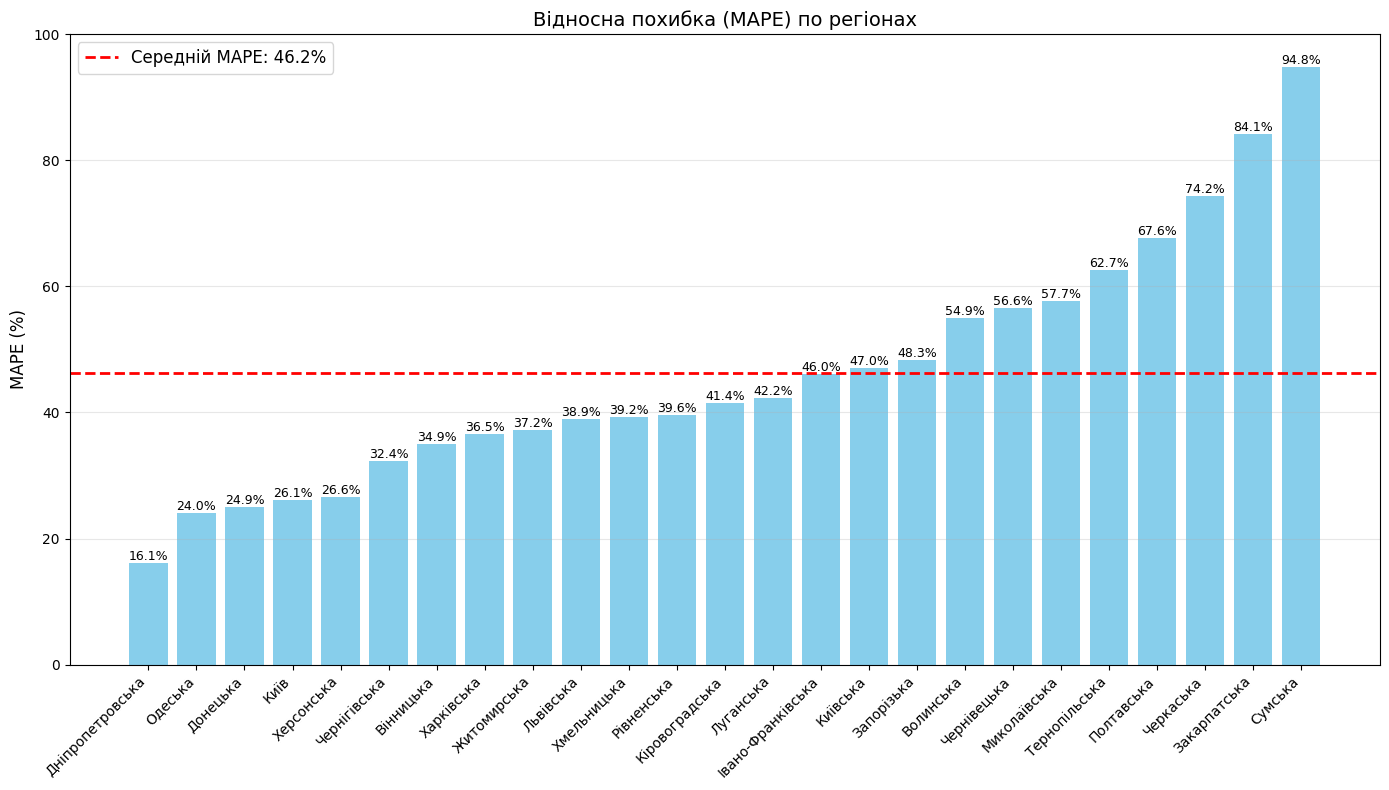

In [101]:
# 2. Побудова та навчання моделі
model_2014_2021.build_model(region_sigma=1, time_sigma=0.85, sigma_obs=1)  # 
model_2014_2021.train_model(samples=5000, tune=2500, chains=1)
metrics = model_2014_2021.evaluate_model()

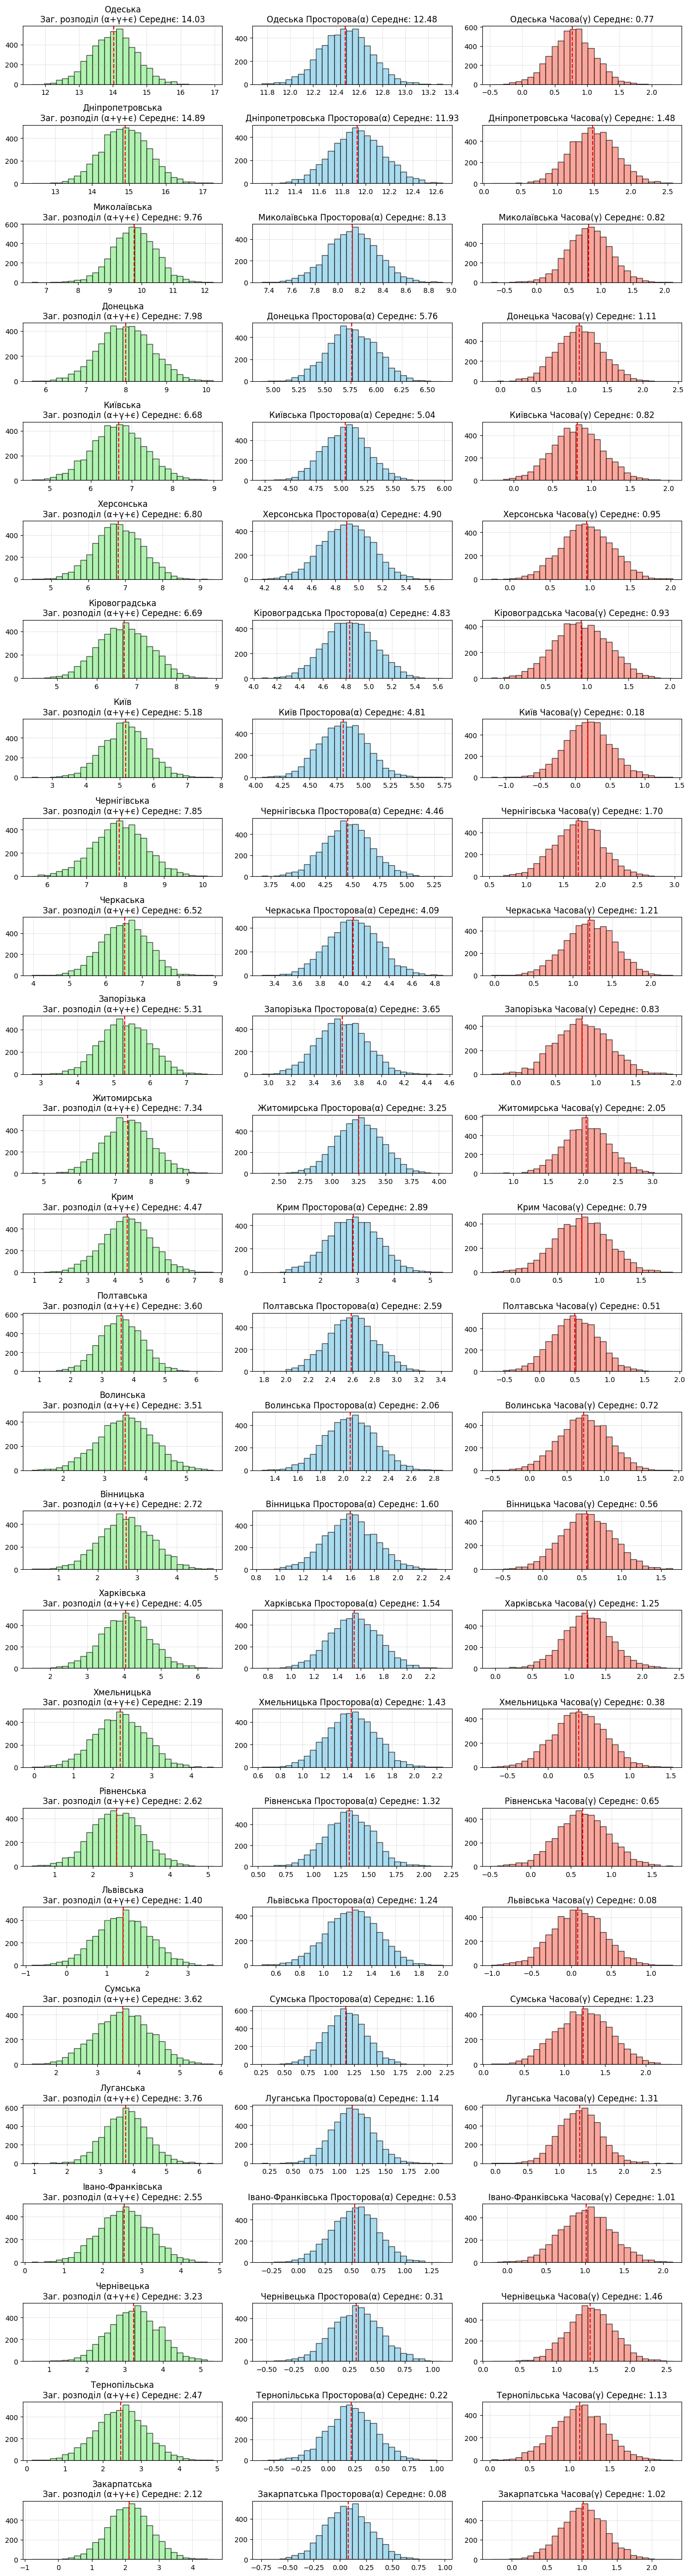


Результати аналізу компонентів:
Область              | Загальне середнє |  Загальний 2.5% | Загальний 97.5% |      Просторова |          Часова
------------------------------------------------------------------------------------------------------------------------
Одеська              |           14.03 |           12.67 |           15.35 |           12.48 |            0.77
Дніпропетровська     |           14.89 |           13.66 |           16.14 |           11.93 |            1.48
Миколаївська         |            9.76 |            8.42 |           11.09 |            8.13 |            0.82
Донецька             |            7.98 |            6.69 |            9.26 |            5.76 |            1.11
Київська             |            6.68 |            5.38 |            7.97 |            5.04 |            0.82
Херсонська           |            6.80 |            5.55 |            8.04 |            4.90 |            0.95
Кіровоградська       |            6.69 |            5.44 |          

In [102]:
components_df = model_2014_2021.plot_full_components_distribution(top_n=26)

In [ ]:
# 5. Підбір оптимальних параметрів
#print("\nПідбір оптимальних параметрів...")
param_grid = {
    'region_sigma': [5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.5], 
    'time_sigma': [5, 5.1, 5.2, 5.25, 5.3, 5.4],
    'sigma_obs': [0.45, 0.5, 0.55]
}
# best_params = model.optimize_parameters(param_grid, samples=4000, tune=2000)

In [ ]:
# 6. Навчання моделі з оптимальними параметрами
# model_params = {k: v for k, v in best_params.items() 
#               if k in ['sigma_region', 'sigma_time', 'sigma_obs', 'mu_overall_sigma']}
# model.build_model(**model_params)
#print("\nОцінка якості моделі...")
#metrics = model_2014_2021.evaluate_model()

Sampling: []
Sampling: []



Прогнозування на червень 2025...
               Region Region_ID  Total_Rate_Pred       Date
14            Одеська      UA51        12.502770 2025-06-01
3    Дніпропетровська      UA12        11.950152 2025-06-01
13       Миколаївська      UA48         8.154600 2025-06-01
4            Донецька      UA14         5.786803 2025-06-01
9            Київська      UA30         5.061501 2025-06-01
7          Херсонська      UA65         4.919287 2025-06-01
10     Кіровоградська      UA35         4.857143 2025-06-01
24               Київ      UA32         4.833649 2025-06-01
1        Чернігівська      UA74         4.479361 2025-06-01
0           Черкаська      UA71         4.111743 2025-06-01
22         Запорізька      UA23         3.674505 2025-06-01
23        Житомирська      UA18         3.275243 2025-06-01
25               Крим      UA43         2.912792 2025-06-01
15         Полтавська      UA53         2.613197 2025-06-01
20          Волинська      UA07         2.086934 2025-06-01
19    

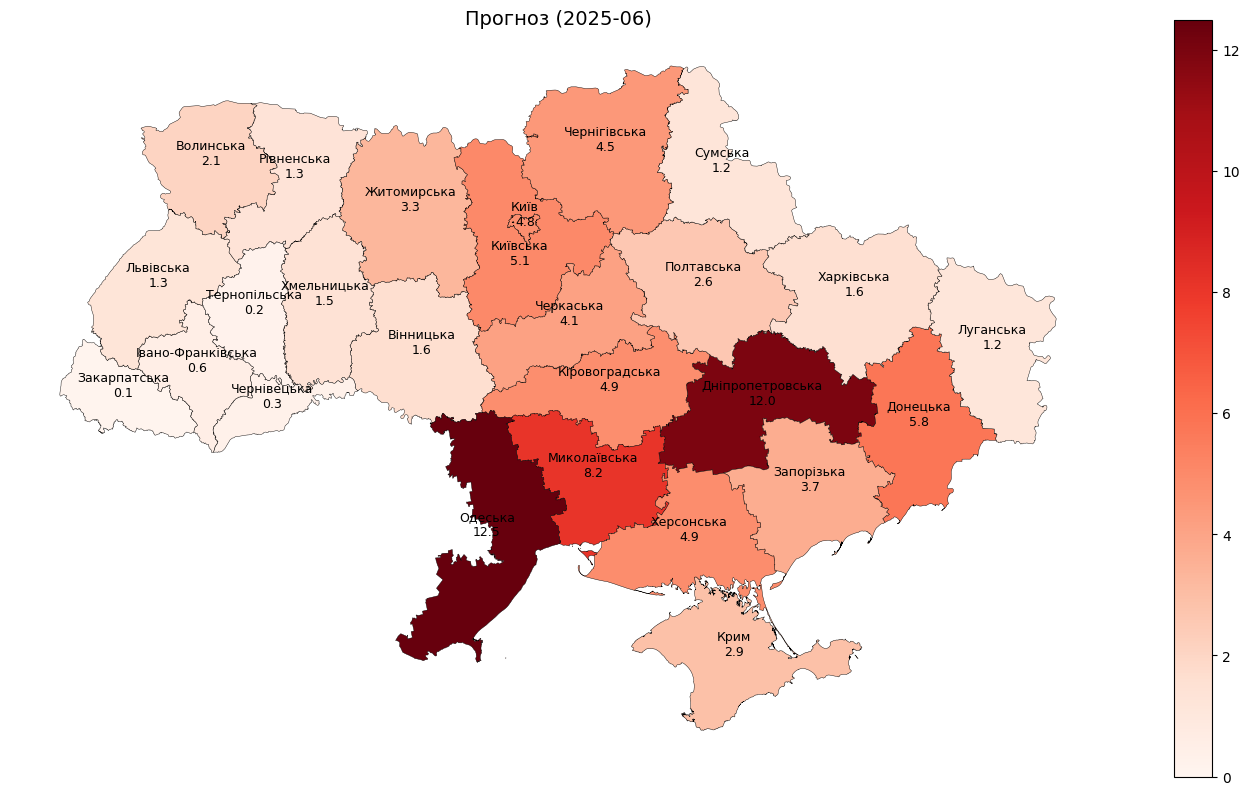

In [103]:
# 7. Прогнозування на майбутній період
print("\nПрогнозування на червень 2025...")
future_pred = model_2014_2021.predict_total_rate("2025-06-01")
print(future_pred.sort_values("Total_Rate_Pred", ascending=False).head(30))
model_2014_2021.plot_spatial_prediction("2025-06-01")

### Модель 2 (2022-2024)

In [104]:
# 1. Ініціалізація та підготовка даних
model_2022_2024 = HIVSpatioTemporalModel("2Модель(2022-2024)")
model_2022_2024.prepare_data("CSV/cleaned_hiv_data.csv", 
                  start_date="2022-01-01", 
                  end_date="2024-12-31")

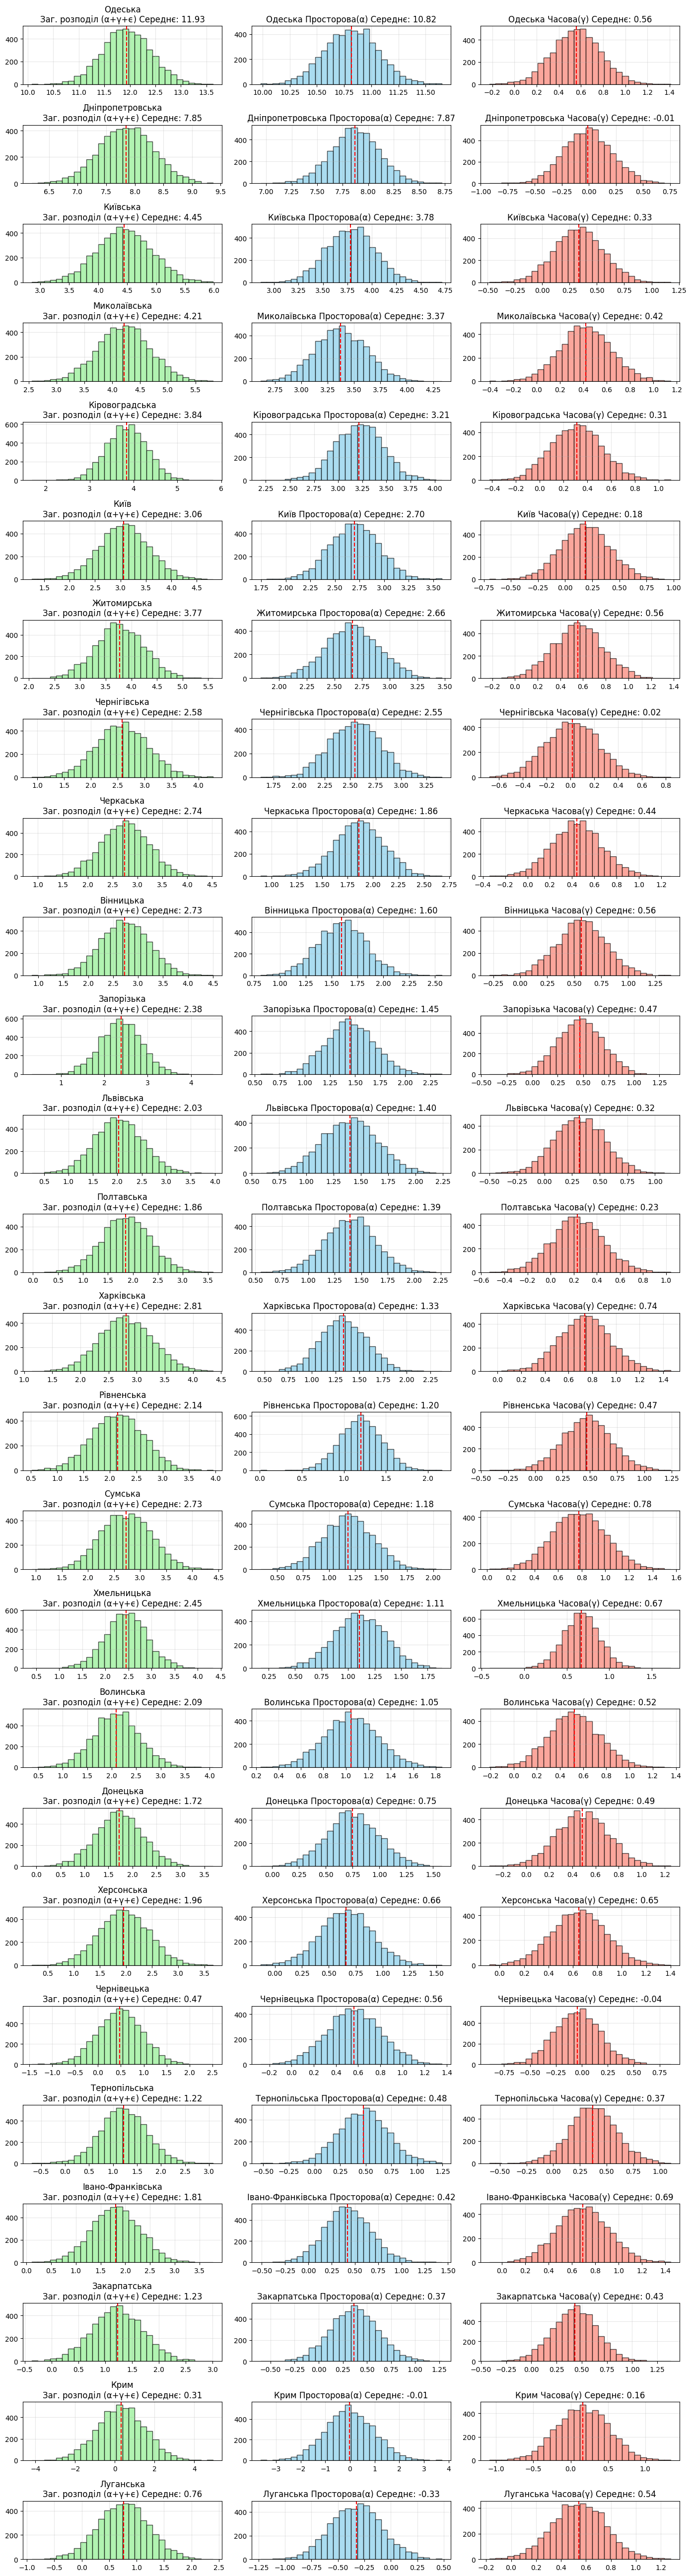


Результати аналізу компонентів:
Область              | Загальне середнє |  Загальний 2.5% | Загальний 97.5% |      Просторова |          Часова
------------------------------------------------------------------------------------------------------------------------
Одеська              |           11.93 |           11.00 |           12.87 |           10.82 |            0.56
Дніпропетровська     |            7.85 |            6.91 |            8.79 |            7.87 |           -0.01
Київська             |            4.45 |            3.50 |            5.37 |            3.78 |            0.33
Миколаївська         |            4.21 |            3.28 |            5.14 |            3.37 |            0.42
Кіровоградська       |            3.84 |            2.94 |            4.74 |            3.21 |            0.31
Київ                 |            3.06 |            2.07 |            4.03 |            2.70 |            0.18
Житомирська          |            3.77 |            2.84 |          

In [106]:
components_df = model_2022_2024.plot_full_components_distribution(top_n=26)

Sampling: []
Sampling: []



Прогнозування на червень 2025...
               Region Region_ID  Total_Rate_Pred       Date
14            Одеська      UA51        10.822436 2025-06-01
3    Дніпропетровська      UA12         7.874229 2025-06-01
9            Київська      UA30         3.787929 2025-06-01
13       Миколаївська      UA48         3.377343 2025-06-01
10     Кіровоградська      UA35         3.219966 2025-06-01
24               Київ      UA32         2.701151 2025-06-01
23        Житомирська      UA18         2.667506 2025-06-01
1        Чернігівська      UA74         2.552023 2025-06-01
0           Черкаська      UA71         1.865029 2025-06-01
19          Вінницька      UA05         1.603308 2025-06-01
22         Запорізька      UA23         1.454036 2025-06-01
12          Львівська      UA46         1.402984 2025-06-01
15         Полтавська      UA53         1.399242 2025-06-01
6          Харківська      UA63         1.339760 2025-06-01
16         Рівненська      UA56         1.206990 2025-06-01
17    

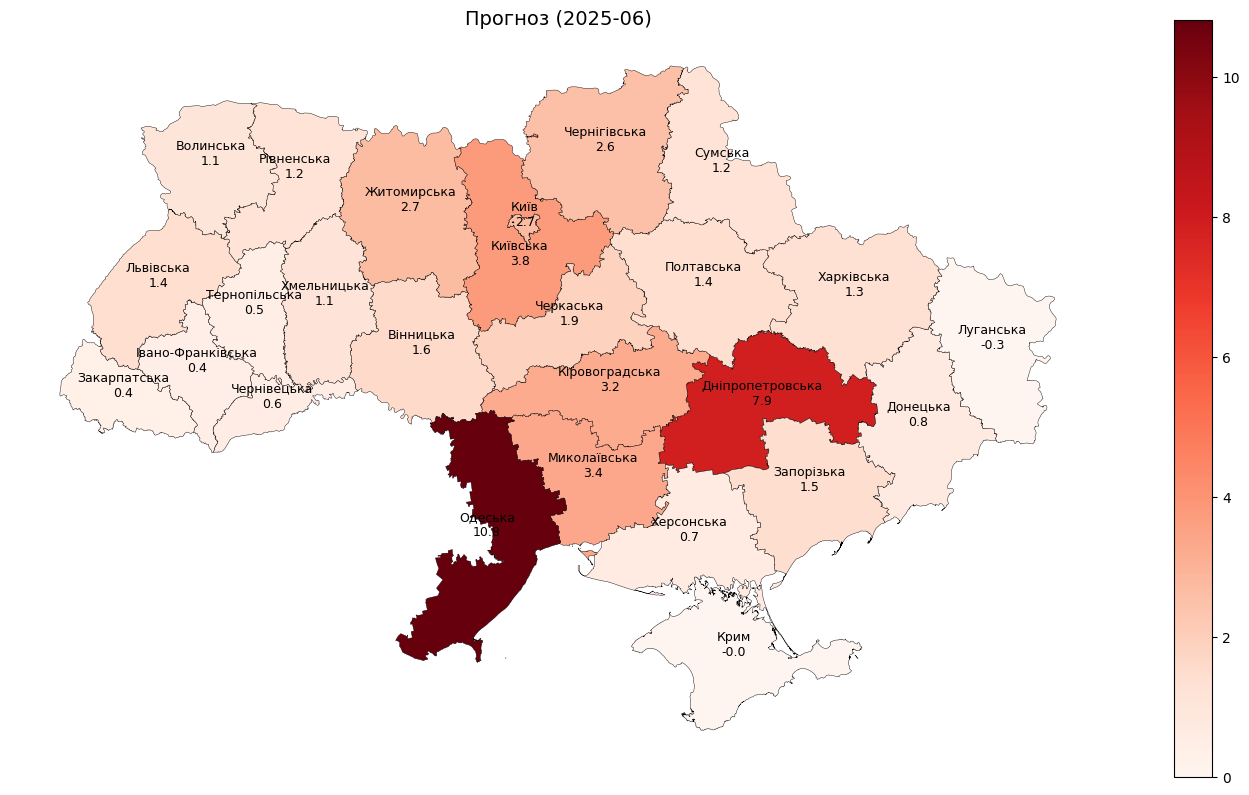

In [107]:
# 3. Прогнозування на майбутній період
print("\nПрогнозування на червень 2025...")
future_pred = model_2022_2024.predict_total_rate("2025-06-01")
print(future_pred.sort_values("Total_Rate_Pred", ascending=False).head(30))
model_2022_2024.plot_spatial_prediction("2025-06-01")

Sampling: []
Sampling: []


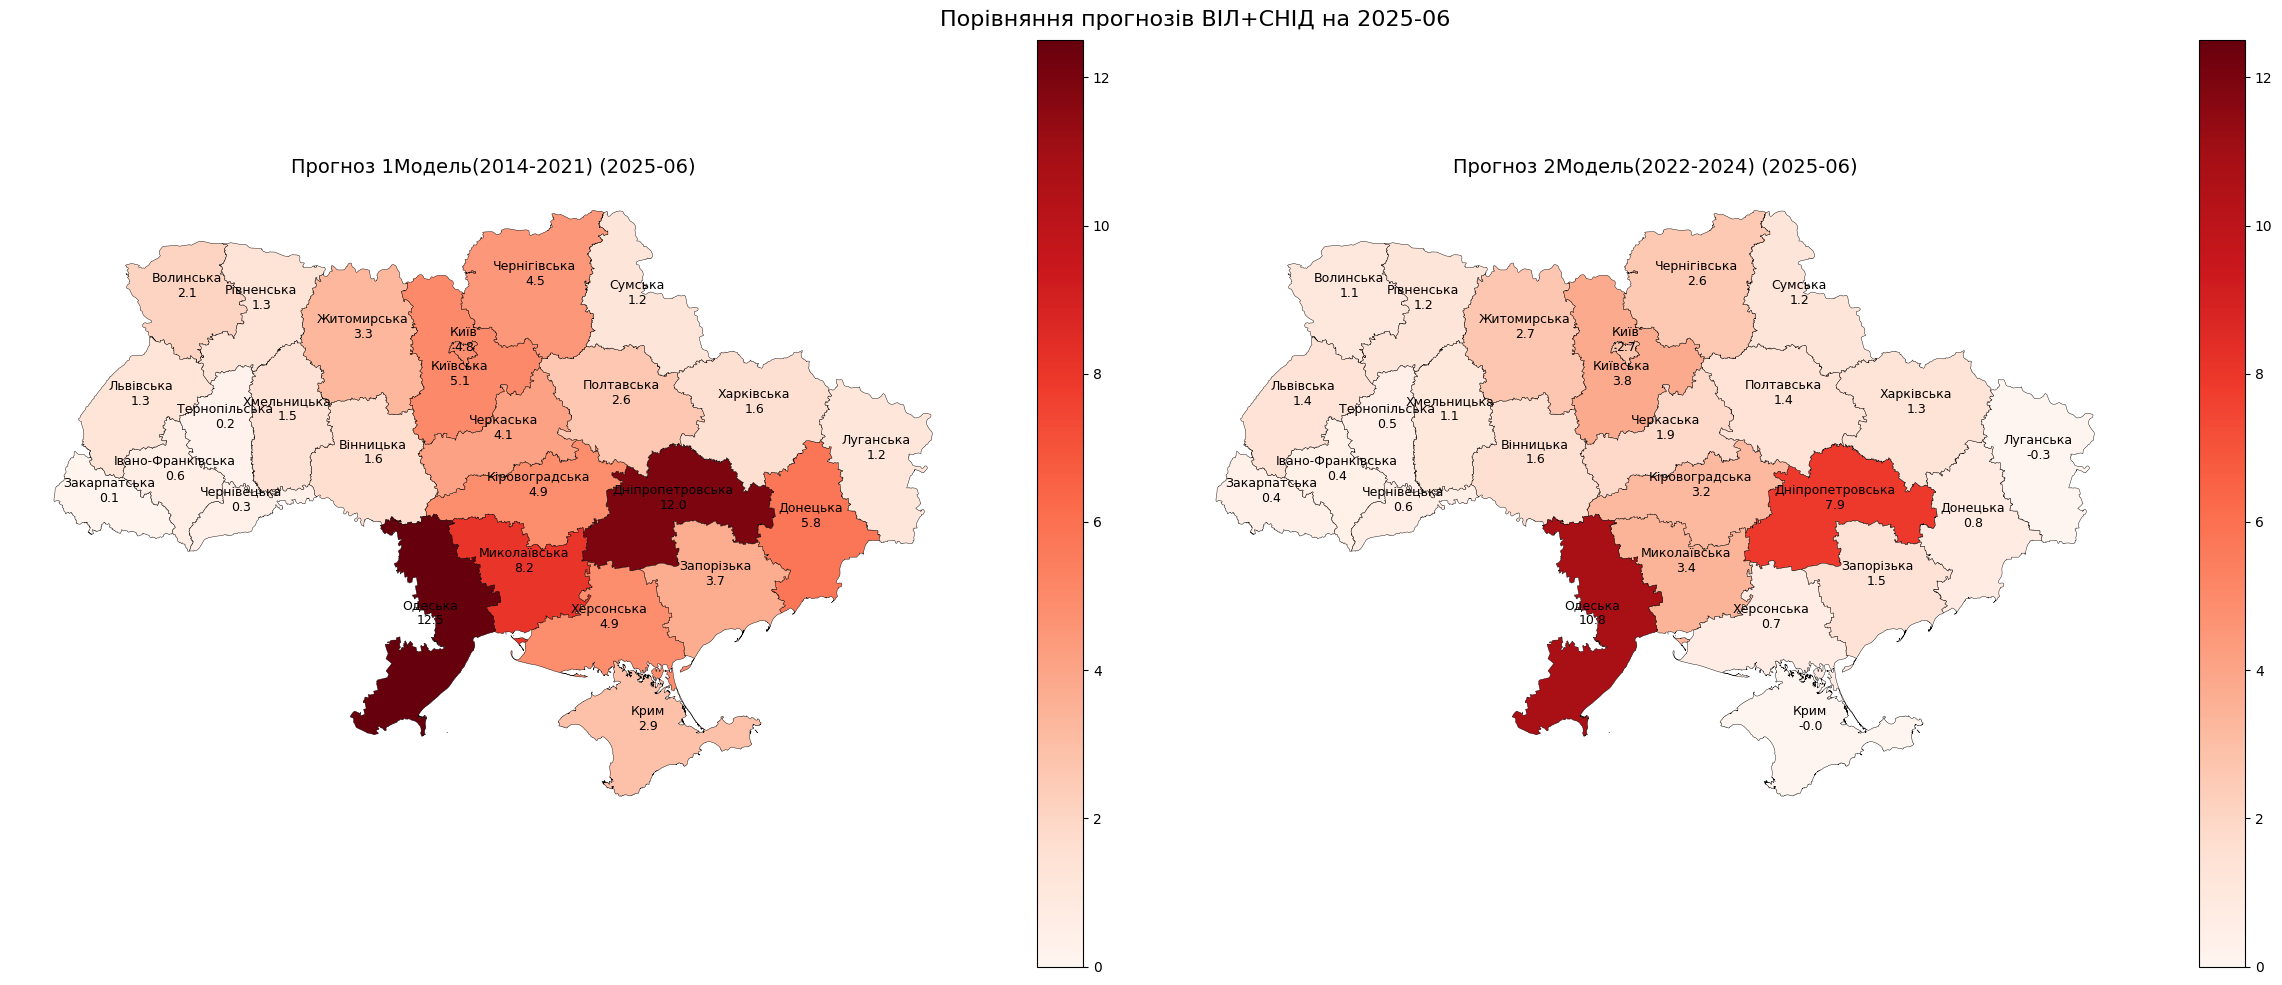

In [108]:
model_2014_2021.plot_models_comparison(model_2022_2024, "2025-06-01")

In [109]:
# Реальні дані на квітень 2025 (приклад)
actual_data_2025_04 = {
    'Черкаська': 2.2,
    'Чернігівська': 3.3,
    'Дніпропетровська': 5.8,
    'Донецька': 0.5,
    'Івано-Франківська': 0.5,
    'Харківська': 1.2,
    'Херсонська': 0.5,
    'Хмельницька': 2.0,
    'Київська': 3.7,
    'Кіровоградська': 4.5,
    'Луганська': 0.0,
    'Львівська': 1.6,
    'Миколаївська': 3.2,
    'Одеська': 7.7,
    'Полтавська': 2.2,
    'Рівненська': 1.2,
    'Сумська': 1.3,
    'Тернопільська': 0.7,
    'Вінницька': 2.0,
    'Волинська': 1.6,
    'Закарпатська': 0.5,
    'Запорізька': 1.2,
    'Житомирська': 3.1,
    'Київ': 3.4,
    "Крим": 0.0
     
}

Sampling: []
Sampling: []


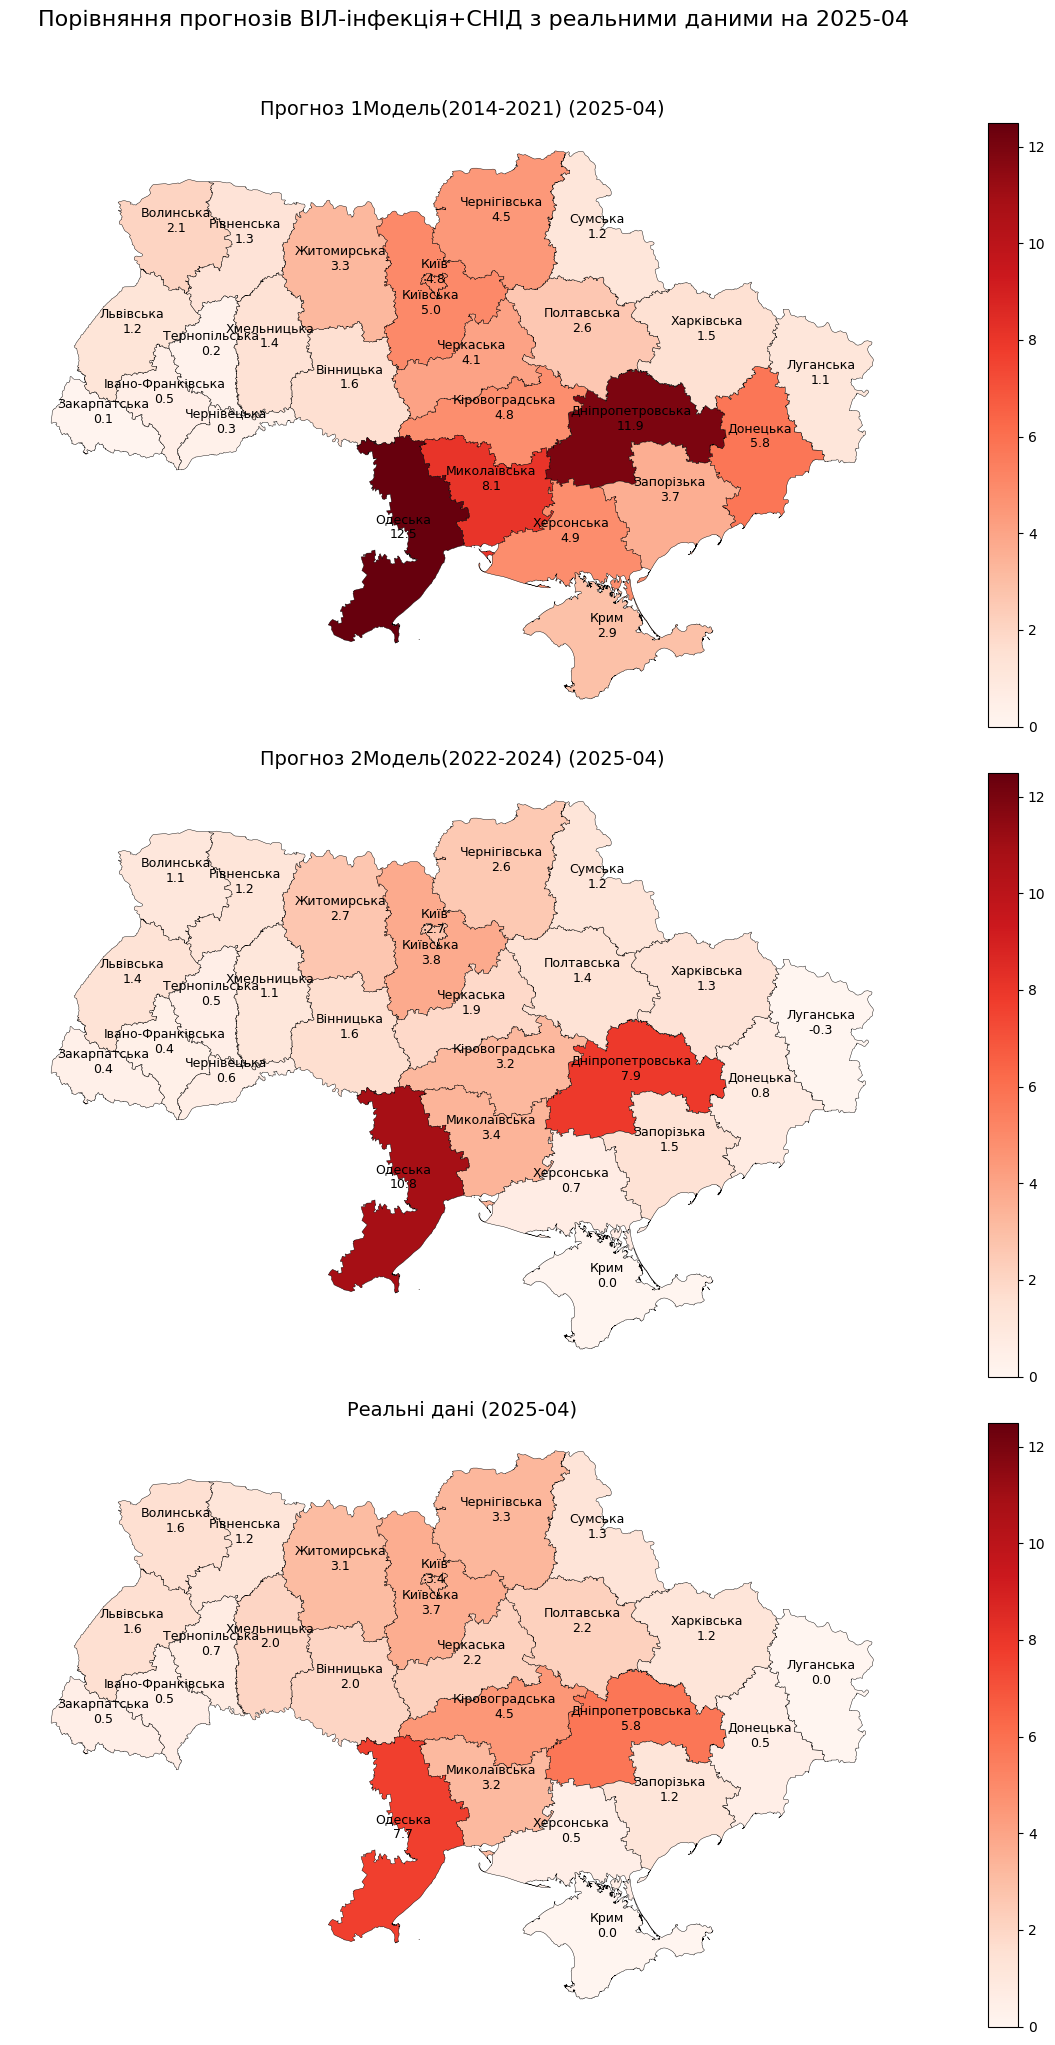

In [110]:
# Порівняння прогнозів двох моделей з реальними даними
model_2014_2021.plot_models_comparison_with_actual(
    model_2022_2024, 
    actual_data_2025_04, 
    "2025-04-01"
)

In [111]:
future_pred = model_2022_2024.predict_total_rate("2025-04-01")
predictions_dict = dict(zip(future_pred['Region'], future_pred['Total_Rate_Pred']))
result_df = model_2022_2024.compare_predictions_with_actual(predictions_dict, actual_data_2025_04)

Sampling: []



Порівняння прогнозу з реальними даними:
Область              | Реальні дані |      Прогноз |  Похибка (%)
-------------------------------------------------------------------
Одеська              |          7.7 |         10.8 |         40.6 %
Дніпропетровська     |          5.8 |          7.9 |         35.9 %
Кіровоградська       |          4.5 |          3.2 |         28.3 %
Київська             |          3.7 |          3.8 |          2.5 %
Київ                 |          3.4 |          2.7 |         20.4 %
Чернігівська         |          3.3 |          2.6 |         22.5 %
Миколаївська         |          3.2 |          3.4 |          5.7 %
Житомирська          |          3.1 |          2.7 |         13.7 %
Полтавська           |          2.2 |          1.4 |         36.1 %
Черкаська            |          2.2 |          1.9 |         14.9 %
Хмельницька          |          2.0 |          1.1 |         44.0 %
Вінницька            |          2.0 |          1.6 |         19.5 %
Львівська